In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json # Para guardar los datos del scaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tf2onnx
import onnx

# Configuración visual
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

print("Librerías cargadas correctamente.")

print("TensorFlow version:", tf.__version__)
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))
tf.test.is_built_with_cuda()





Librerías cargadas correctamente.
TensorFlow version: 2.15.0
GPUs disponibles: []


False

In [2]:
# 1. Cargar el archivo limpio
file_path = 'datos_limpios.csv' 

try:
    df = pd.read_csv(file_path)
    print(f"Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")
except FileNotFoundError:
    raise Exception("No se encuentra 'datos_limpios.csv'. Asegúrate de haberlo generado.")

# 2. Separar X (Sensores) e y (Acciones) basándonos en los prefijos
cols_sensores = [c for c in df.columns if c.startswith('S_')]
cols_acciones = [c for c in df.columns if c.startswith('A_')]

X = df[cols_sensores]
y = df[cols_acciones]

print(f"Inputs (Sensores): {X.shape[1]} variables")
print(f"Outputs (Acciones): {y.shape[1]} variables ({list(y.columns)})")

Datos cargados: 125532 filas, 27 columnas
Inputs (Sensores): 23 variables
Outputs (Acciones): 4 variables (['A_Accel', 'A_Brake', 'A_Gear', 'A_Steer'])


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

orden_correcto = ['A_Accel', 'A_Brake', 'A_Gear', 'A_Steer'] 
y = y[orden_correcto]

# 1. Dividir datos: 70% para entrenar, 30% para validar
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 2. Ajustar el Escalador SOLO con los datos de entrenamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 3. Convertir salidas a NumPy (EVITA errores con Keras multi-output)
y_train = y_train.values
y_test  = y_test.values

print("Tamaño de X_train:", X_train.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Tamaño de y_test:", y_test.shape)

print("Datos normalizados y salidas convertidas a NumPy correctamente.")


Tamaño de X_train: (87872, 23)
Tamaño de y_train: (87872, 4)
Tamaño de X_test: (37660, 23)
Tamaño de y_test: (37660, 4)
Datos normalizados y salidas convertidas a NumPy correctamente.



--- CONSTRUYENDO Y ENTRENANDO RED ACCEL ---

Epoch 1/50

1373/1373 [==============================] - 4s 2ms/step - loss: 0.0645 - mae: 0.1763 - val_loss: 0.0475 - val_mae: 0.1396
Epoch 2/50
1373/1373 [==============================] - 3s 2ms/step - loss: 0.0441 - mae: 0.1293 - val_loss: 0.0393 - val_mae: 0.1177
Epoch 3/50
1373/1373 [==============================] - 3s 2ms/step - loss: 0.0384 - mae: 0.1135 - val_loss: 0.0359 - val_mae: 0.1053
Epoch 4/50
1373/1373 [==============================] - 3s 2ms/step - loss: 0.0348 - mae: 0.1045 - val_loss: 0.0330 - val_mae: 0.1018
Epoch 5/50
1373/1373 [==============================] - 3s 2ms/step - loss: 0.0318 - mae: 0.0981 - val_loss: 0.0294 - val_mae: 0.0948
Epoch 6/50
1373/1373 [==============================] - 3s 2ms/step - loss: 0.0293 - mae: 0.0928 - val_loss: 0.0277 - val_mae: 0.0915
Epoch 7/50
1373/1373 [==============================] - 3s 2ms/step - loss: 0.0269 - mae: 0.0885 - val_loss: 0.0252 - val_mae: 0.0873
Epoch 8/50
1373

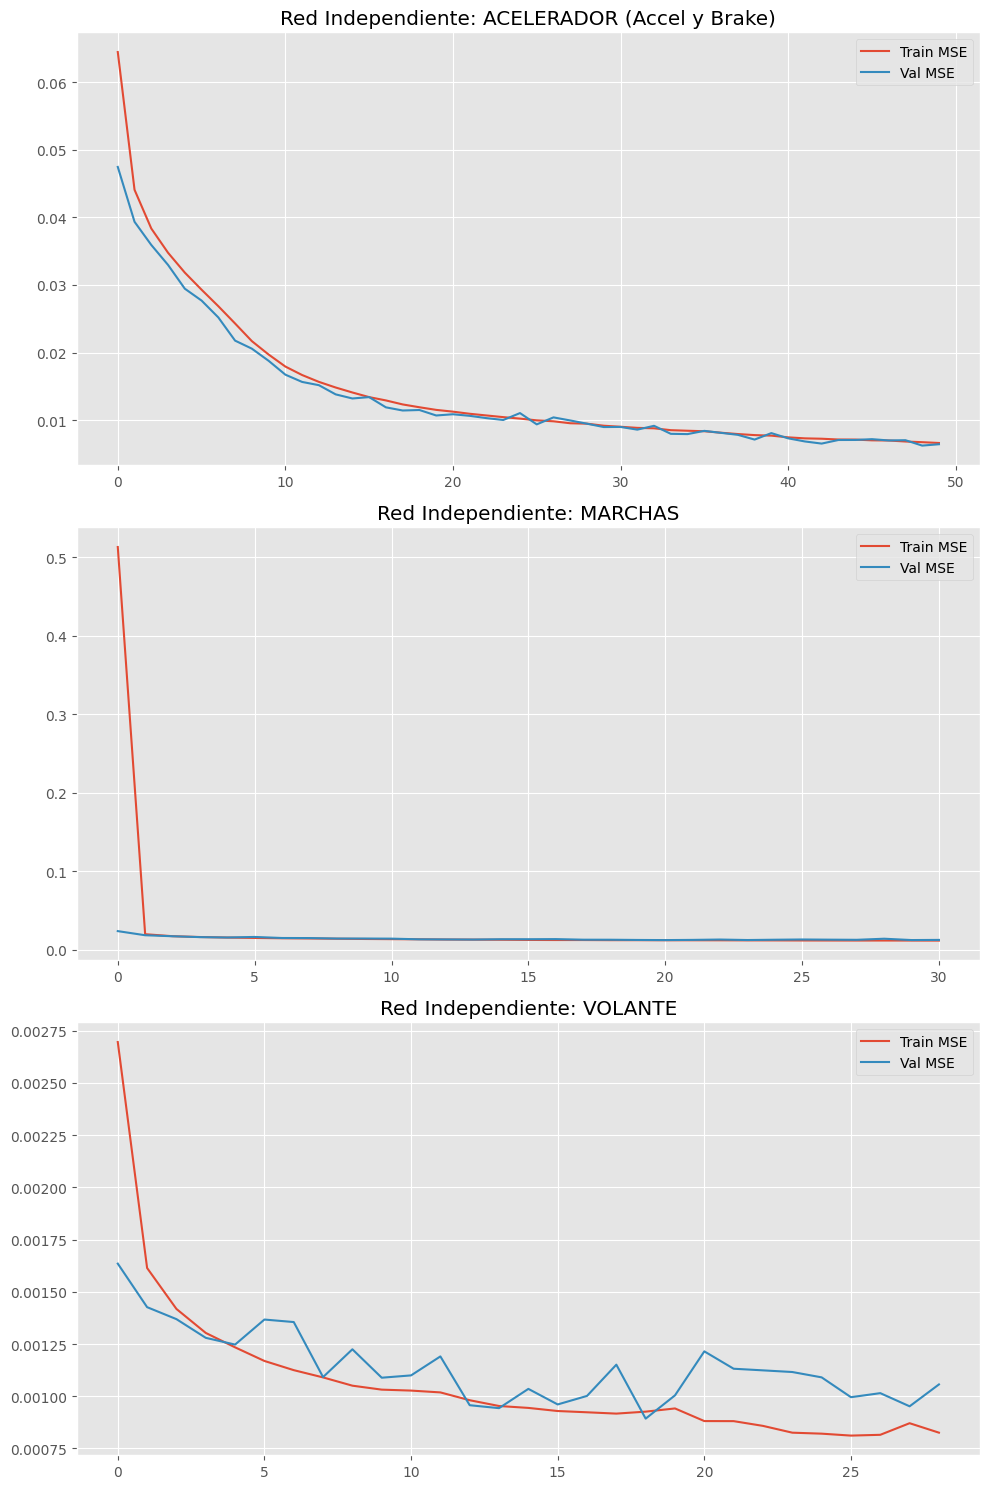

Modelos entrenados por separado.


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. CONFIGURACIÓN COMÚN (Features)
# ==========================================

feature_idx = {
 # --- Sensores Escalares ---
    'S_speed':          X.columns.get_loc('S_speed'),
    'S_rpm':            X.columns.get_loc('S_rpm'),
    'S_gear':           X.columns.get_loc('S_gear'),
    'S_angle':          X.columns.get_loc('S_angle'),
    'S_trackPos':       X.columns.get_loc('S_trackPos'),
    'S_z':              X.columns.get_loc('S_z'),
    'S_wheelSpinVel_0': X.columns.get_loc('S_wheelSpinVel_0'),

    # --- Sensores de Pista (Solo los solicitados) ---
    'S_track_0':        X.columns.get_loc('S_track_0'),
    'S_track_3':        X.columns.get_loc('S_track_3'),
    'S_track_4':        X.columns.get_loc('S_track_4'),
    'S_track_5':        X.columns.get_loc('S_track_5'),
    'S_track_6':        X.columns.get_loc('S_track_6'),     
    'S_track_7':        X.columns.get_loc('S_track_7'),
    'S_track_8':        X.columns.get_loc('S_track_8'),
    'S_track_9':        X.columns.get_loc('S_track_9'),
    'S_track_10':       X.columns.get_loc('S_track_10'),
    'S_track_11':       X.columns.get_loc('S_track_11'),
    'S_track_12':       X.columns.get_loc('S_track_12'),
    'S_track_13':       X.columns.get_loc('S_track_13'),
    'S_track_14':       X.columns.get_loc('S_track_14'),
    'S_track_15':       X.columns.get_loc('S_track_15'),
    'S_track_16':       X.columns.get_loc('S_track_16'),
    'S_track_17':       X.columns.get_loc('S_track_17'),

}

input_shape = (X_train_scaled.shape[1],)

# Callback opcional para parar si deja de aprender (ahorra tiempo)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ==========================================
# 2. RED 1: ACELERADOR (Accel)
# ==========================================
# La aceleracion contiene el freno tambien
print("\n--- CONSTRUYENDO Y ENTRENANDO RED ACCEL ---")

# Selección de features
accel_features = [
    feature_idx['S_speed'],
    feature_idx['S_track_9'], 
    feature_idx['S_wheelSpinVel_0'],
    feature_idx['S_track_8'],
    feature_idx['S_track_10'],
    feature_idx['S_rpm'],
]

# Arquitectura
inp_a = Input(shape=input_shape, name='input_accel')
sel_a = Lambda(lambda x: tf.gather(x, accel_features, axis=1))(inp_a)
x_a = Dense(32, activation='relu')(sel_a)
x_a = Dense(16, activation='relu')(x_a)
out_a = Dense(2, activation='sigmoid', name='output_accel')(x_a)

model_accel = Model(inputs=inp_a, outputs=out_a, name="Model_Accel")

model_accel.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Entrenamiento (Solo usamos la columna 0 de Y)
history_accel = model_accel.fit(
    X_train_scaled, y_train[:, 0:2], # <--- OJO: Seleccionamos slice [:, 0:2] que toma las columnas 0 y 1
    validation_data=(X_test_scaled, y_test[:, 0:2]),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# ==========================================
# 3. RED 2: MARCHAS (Gear)
# ==========================================
print("\n--- CONSTRUYENDO Y ENTRENANDO RED GEAR ---")

# Selección de features
gear_features = [
    feature_idx['S_gear'], 
    feature_idx['S_speed'], 
    feature_idx['S_wheelSpinVel_0'], 
    feature_idx['S_z'], 
    feature_idx['S_track_9'], 
]

# Arquitectura
inp_g = Input(shape=input_shape, name='input_gear')
sel_g = Lambda(lambda x: tf.gather(x, gear_features, axis=1))(inp_g)
x_g = Dense(24, activation='relu')(sel_g)
x_g = Dense(12, activation='relu')(x_g)
out_g = Dense(1, activation='linear', name='output_gear')(x_g)

model_gear = Model(inputs=inp_g, outputs=out_g, name="Model_Gear")

model_gear.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Entrenamiento (Solo usamos la columna 1 de Y)
history_gear = model_gear.fit(
    X_train_scaled, y_train[:, 2], # <--- OJO: Solo columna 1
    validation_data=(X_test_scaled, y_test[:, 2]),
    epochs=50, 
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# ==========================================
# 4. RED 3: VOLANTE (Steer)
# ==========================================
print("\n--- CONSTRUYENDO Y ENTRENANDO RED STEER ---")

# Selección de features
steer_features = [
    feature_idx['S_track_4'],
    feature_idx['S_track_14'],
    feature_idx['S_track_15'],
    feature_idx['S_track_3'],
    feature_idx['S_track_13'],
    feature_idx['S_angle'],
    feature_idx['S_track_16'],
    feature_idx['S_trackPos'],
    feature_idx['S_track_12'],
    feature_idx['S_speed'],
    feature_idx['S_track_17'],
    feature_idx['S_track_5'],
    feature_idx['S_track_6'],
    feature_idx['S_track_8'],
    feature_idx['S_track_10'],
    feature_idx['S_track_0'],
    feature_idx['S_track_7'],
    feature_idx['S_track_11'],
]

# Arquitectura (Podemos hacerla más profunda o lenta si es necesario)
inp_s = Input(shape=input_shape, name='input_steer')
sel_s = Lambda(lambda x: tf.gather(x, steer_features, axis=1))(inp_s)

x_s = Dense(128, activation='relu')(sel_s)
x_s = Dropout(0.1)(x_s)  # Pequeño dropout para evitar memorizar curvas exactas
x_s = Dense(64, activation='relu')(x_s)
x_s = Dense(32, activation='relu')(x_s)
x_s = Dense(16, activation='relu')(x_s)
out_s = Dense(1, activation='tanh', name='output_steer')(x_s)

model_steer = Model(inputs=inp_s, outputs=out_s, name="Model_Steer")

# Podrías bajar el learning rate aquí si el volante tiembla mucho
model_steer.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Entrenamiento (Solo usamos la columna 2 de Y)
history_steer = model_steer.fit(
    X_train_scaled, y_train[:, 3], # <--- OJO: Solo columna 2
    validation_data=(X_test_scaled, y_test[:, 3]),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ==========================================
# 5. GRÁFICOS COMPARATIVOS
# ==========================================

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Accel
axs[0].plot(history_accel.history['loss'], label='Train MSE')
axs[0].plot(history_accel.history['val_loss'], label='Val MSE')
axs[0].set_title('Red Independiente: ACELERADOR (Accel y Brake)')
axs[0].legend()
axs[0].grid(True)

# Gear
axs[1].plot(history_gear.history['loss'], label='Train MSE')
axs[1].plot(history_gear.history['val_loss'], label='Val MSE')
axs[1].set_title('Red Independiente: MARCHAS')
axs[1].legend()
axs[1].grid(True)

# Steer
axs[2].plot(history_steer.history['loss'], label='Train MSE')
axs[2].plot(history_steer.history['val_loss'], label='Val MSE')
axs[2].set_title('Red Independiente: VOLANTE')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# ==========================================
# 6. GUARDADO DE MODELOS
# ==========================================
# model_accel.save('model_accel.keras')
# model_gear.save('model_gear.keras')
# model_steer.save('model_steer.keras')
print("Modelos entrenados por separado.")

In [5]:
import tf2onnx
import onnx
import tensorflow as tf

# 1. Definimos la firma de entrada
# (Es idéntica para las tres redes porque todas reciben el mismo array de sensores)
spec = (
    tf.TensorSpec(
        (None, X_train_scaled.shape[1]), # Usamos la forma de tus datos escalados
        tf.float32,
        name="input_sensores"
    ),
)

# 2. Lista de modelos a convertir y sus nombres de salida
modelos_exportar = [
    (model_accel, "cerebro_pedales.onnx"),
    (model_gear,  "cerebro_gear.onnx"),
    (model_steer, "cerebro_steer.onnx")
]

print("=== INICIANDO EXPORTACIÓN A ONNX (3 REDES) ===\n")

for modelo, nombre_archivo in modelos_exportar:
    print(f"--> Convirtiendo '{modelo.name}'...")
    
    # Conversión
    model_proto, _ = tf2onnx.convert.from_keras(
        modelo,
        input_signature=spec,
        opset=13,
        output_path=nombre_archivo
    )
    
    print(f"    Guardado en: {nombre_archivo}")
    print(f"    Nombre de salida interna: {[o.name for o in model_proto.graph.output]}")
    print("-" * 30)

print("\n¡ÉXITO! Tienes 3 archivos .onnx listos para usar.")

=== INICIANDO EXPORTACIÓN A ONNX (3 REDES) ===

--> Convirtiendo 'Model_Accel'...
    Guardado en: cerebro_pedales.onnx
    Nombre de salida interna: ['output_accel']
------------------------------
--> Convirtiendo 'Model_Gear'...
    Guardado en: cerebro_gear.onnx
    Nombre de salida interna: ['output_gear']
------------------------------
--> Convirtiendo 'Model_Steer'...
    Guardado en: cerebro_steer.onnx
    Nombre de salida interna: ['output_steer']
------------------------------

¡ÉXITO! Tienes 3 archivos .onnx listos para usar.


Generando predicciones sobre datos de test...

      REPORTE DE CALIDAD (MÉTRICAS + F1)
Variable: ACELERADOR
  -> R2 Score (Precisión): 0.9474  (Ideal: 1.0)
  -> Error Medio (MAE):    0.0520
  -> F1 SCORE: N/A (Continua)
  -> Estado: EXCELENTE 🟢

Variable: FRENO
  -> R2 Score (Precisión): 0.8840  (Ideal: 1.0)
  -> Error Medio (MAE):    0.0252
  -> F1 SCORE: N/A (Continua)
  -> Estado: EXCELENTE 🟢

Variable: MARCHAS
  -> R2 Score (Precisión): 0.9897  (Ideal: 1.0)
  -> Error Medio (MAE):    0.0375
  -> F1 SCORE: 0.9840 🌟 (Precisión de cambio de marcha)
  -> Estado: EXCELENTE 🟢

Variable: VOLANTE
  -> R2 Score (Precisión): 0.9478  (Ideal: 1.0)
  -> Error Medio (MAE):    0.0083
  -> F1 SCORE: N/A (Continua)
  -> Estado: EXCELENTE 🟢



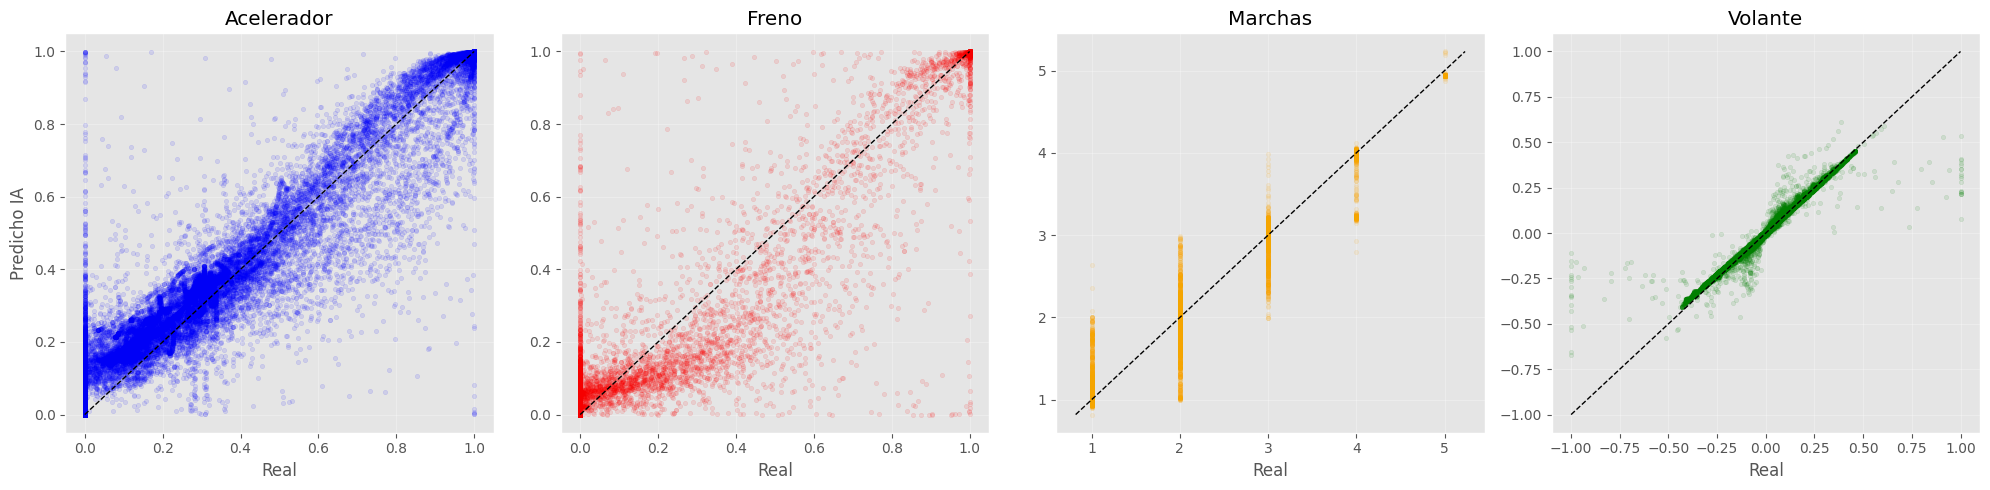

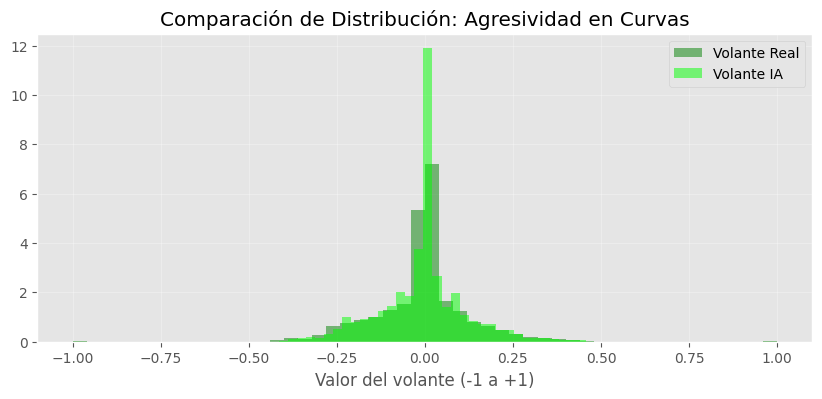

In [8]:
# ============================
# 10. EVALUACIÓN Y ESTADÍSTICAS DETALLADAS 
# ============================

from sklearn.metrics import r2_score, mean_absolute_error, f1_score
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. GENERACIÓN Y ORGANIZACIÓN DE PREDICCIONES
# ------------------------------------------------------------------
print("Generando predicciones sobre datos de test...")

# 1. Obtenemos las predicciones crudas de cada modelo
raw_pedals = model_accel.predict(X_test_scaled, verbose=0) # Salida: (N, 2) -> [Accel, Brake]
raw_gear   = model_gear.predict(X_test_scaled, verbose=0)  # Salida: (N, 1) -> [Gear]
raw_steer  = model_steer.predict(X_test_scaled, verbose=0) # Salida: (N, 1) -> [Steer]

# 2. SEPARACIÓN MANUAL (AQUÍ ESTÁ LA SOLUCIÓN AL ERROR)
# Desempaquetamos la primera red en dos vectores separados
pred_accel = raw_pedals[:, 0] # Solo columna 0 (Acelerador)
pred_brake = raw_pedals[:, 1] # Solo columna 1 (Freno)
pred_gear  = raw_gear.flatten()
pred_steer = raw_steer.flatten()

# 3. Lista ordenada igual que y_test
# Orden esperado de y_test: [Accel, Brake, Gear, Steer]
preds_ordenadas = [pred_accel, pred_brake, pred_gear, pred_steer]
nombres_salidas = ['Acelerador', 'Freno', 'Marchas', 'Volante']

# ------------------------------------------------------------------
# 2. REPORTE NUMÉRICO
# ------------------------------------------------------------------
print("\n" + "="*60)
print("      REPORTE DE CALIDAD (MÉTRICAS + F1)")
print("="*60)

for i, nombre in enumerate(nombres_salidas):
    # Datos Reales vs Predichos
    real = y_test[:, i]        # Columna i de los datos reales
    pred = preds_ordenadas[i]  # Vector i de nuestra lista ya separada
    
    # --- MÉTRICAS COMUNES ---
    r2 = r2_score(real, pred)
    mae = mean_absolute_error(real, pred)
    
    print(f"Variable: {nombre.upper()}")
    print(f"  -> R2 Score (Precisión): {r2:.4f}  (Ideal: 1.0)")
    print(f"  -> Error Medio (MAE):    {mae:.4f}")
    
    # --- MÉTRICA ESPECIAL PARA MARCHAS (F1) ---
    if nombre == 'Marchas':
        # Redondeamos para tratarlo como clasificación
        real_int = np.rint(real).astype(int)
        pred_int = np.rint(pred).astype(int)
        
        f1 = f1_score(real_int, pred_int, average='weighted')
        print(f"  -> F1 SCORE: {f1:.4f} 🌟 (Precisión de cambio de marcha)")
    else:
        print(f"  -> F1 SCORE: N/A (Continua)")

    # Estado visual
    if r2 > 0.85:
        estado = "EXCELENTE 🟢"
    elif r2 > 0.6:
        estado = "ACEPTABLE 🟡"
    else:
        estado = "MALO / NO APRENDE 🔴"
    print(f"  -> Estado: {estado}\n")

# ------------------------------------------------------------------
# 3. GRÁFICOS DE DISPERSIÓN (REAL VS PREDICHO)
# ------------------------------------------------------------------
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

colores = ['blue', 'red', 'orange', 'green'] # Azul=Accel, Rojo=Brake, Naranja=Gear, Verde=Steer

for i, ax in enumerate(axs):
    real = y_test[:, i]
    pred = preds_ordenadas[i]
    
    # Scatter plot
    ax.scatter(real, pred, alpha=0.1, color=colores[i], s=10)
    
    # Línea diagonal perfecta
    min_val = min(np.min(real), np.min(pred))
    max_val = max(np.max(real), np.max(pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1, label='Ideal')
    
    ax.set_title(f'{nombres_salidas[i]}')
    ax.set_xlabel('Real')
    if i == 0: ax.set_ylabel('Predicho IA')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 4. HISTOGRAMA COMPARATIVO DEL VOLANTE
# ------------------------------------------------------------------
idx_steer = 3 
plt.figure(figsize=(10, 4))
plt.hist(y_test[:, idx_steer], bins=50, alpha=0.5, label='Volante Real', color='green', density=True)
plt.hist(preds_ordenadas[idx_steer], bins=50, alpha=0.5, label='Volante IA', color='lime', density=True)
plt.title("Comparación de Distribución: Agresividad en Curvas")
plt.xlabel("Valor del volante (-1 a +1)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
import numpy as np
import re # Necesario para procesar los nombres de las columnas

print("="*80)
print("   GENERADOR DE CÓDIGO PARA NeuralDriver.py")
print("   (Versión Definitiva: Doble Salida Pedales + Gear + Steer)")
print("="*80)

# =========================================================================
# BLOQUE A: IMPORTS Y CARGA (__init__)
# =========================================================================
print("\n" + "#" * 40)
print("# BLOQUE A: Copiar dentro de def __init__(self):")
print("#" * 40)

print("""
import onnxruntime as ort
import numpy as np

# 1. Cargar los 3 cerebros ONNX
try:
    # Asegúrate de que los archivos .onnx estén en la carpeta del bot
    self.sess_accel = ort.InferenceSession('cerebro_pedales.onnx') # Acelerador + Freno
    self.sess_gear  = ort.InferenceSession('cerebro_gear.onnx')    # Marchas
    self.sess_steer = ort.InferenceSession('cerebro_steer.onnx')   # Volante
    print('✅ Modelos ONNX cargados correctamente.')
except Exception as e:
    print(f'❌ Error cargando ONNX: {e}')
""")

# Generación dinámica de los arrays del Scaler
print("# 2. Parámetros del Scaler (Generados automáticamente del entrenamiento)")
print("self.scaler_mean = np.array([")
print("    " + ", ".join([f"{x:.8f}" for x in scaler.mean_]))
print("], dtype=np.float32)")

print("\nself.scaler_scale = np.array([")
print("    " + ", ".join([f"{x:.8f}" for x in scaler.scale_]))
print("], dtype=np.float32)")

# -------------------------------------------------------------------------
# BLOQUE B: LECTURA Y EJECUCIÓN (CORREGIDO PARA DOBLE SALIDA)
# -------------------------------------------------------------------------
print("\n" + "-"*40)
print(" BLOQUE B: Copiar en el bucle principal (Update)")
print("-" * 40)

print("# 1. Lectura de Sensores (Orden estricto del entrenamiento)")
print("state = []")

# ... (Tu bucle for de sensores se mantiene igual, ese estaba bien) ...
# Pega aquí tu bucle 'for col in X.columns' original
for col in X.columns: 
    col_lower = col.lower()
    method = None
    if "angle" in col_lower: method = "sensors.getAngle()"
    elif "distraced" in col_lower: method = "sensors.getDistRaced()"
    elif "gear" in col_lower: method = "sensors.getGear()"
    elif "trackpos" in col_lower or "track_pos" in col_lower: method = "sensors.getTrackPos()"
    elif "speedx" in col_lower: method = "sensors.getSpeedX()"
    elif "speedy" in col_lower: method = "sensors.getSpeedY()"
    elif "speed" in col_lower: method = "sensors.getSpeedX()"
    elif "rpm" in col_lower: method = "sensors.getRpm()"
    elif "track" in col_lower and any(char.isdigit() for char in col):
        import re
        numbers = re.findall(r'\d+', col)
        if numbers:
            idx = numbers[-1]
            method = f"sensors.getTracks()[{idx}]"
    elif "wheel" in col_lower and any(char.isdigit() for char in col):
        import re
        numbers = re.findall(r'\d+', col)
        if numbers:
            idx = numbers[-1]
            method = f"sensors.getWheelSpinVel({idx})"
    elif "z" in col_lower: method = "sensors.getZ()[0]"

    if method:
        print(f"state.append({method}) # {col}")
    else:
        print(f"state.append(0.0) # FIXME: '{col}' NO ENCONTRADO")


# --- AQUÍ EMPIEZA LA CORRECCIÓN CRÍTICA ---

print("\n# 2. Preprocesamiento (Escalado)")
print("input_raw = np.array(state, dtype=np.float32)")
print("input_norm = (input_raw - self.scaler_mean) / self.scaler_scale")
print("input_onnx = input_norm.reshape(1, -1)")

print("\n# 3. Inferencia Independiente (3 Cerebros)")
print("# Inicializamos variables por defecto")
print("raw_pedals = [[0.0, 0.0]] # Accel, Brake")
print("pred_gear = 1")
print("pred_steer = 0.0")

print("try:")
print("    # Nombre del input en ONNX")
print("    in_name_a = self.sess_accel.get_inputs()[0].name")
print("    in_name_g = self.sess_gear.get_inputs()[0].name")
print("    in_name_s = self.sess_steer.get_inputs()[0].name")
print("")
print("    # Ejecutamos cada red")
print("    # OJO: sess_accel devuelve [[Accel, Brake]]")
print("    raw_pedals = self.sess_accel.run(None, {in_name_a: input_onnx})[0]")
print("    pred_gear  = self.sess_gear.run(None,  {in_name_g: input_onnx})[0][0][0]")
print("    pred_steer = self.sess_steer.run(None, {in_name_s: input_onnx})[0][0][0]")
print("")
print("except Exception as e:")
print("    print(f'❌ Error en inferencia: {e}')")

print("\n# 4. Procesado de Salida (Extracción y Limpieza)")
print("# Desempaquetamos Pedales (Columna 0: Accel, Columna 1: Brake)")
print("pred_accel = float(raw_pedals[0][0])")
print("pred_brake = float(raw_pedals[0][1])")
print("")
print("# Aplicamos Clips (Límites físicos)")
print("accel_out = np.clip(pred_accel, 0.0, 1.0)")
print("brake_out = np.clip(pred_brake, 0.0, 1.0)")
print("gear_out  = int(np.clip(np.round(pred_gear), 1, 6))")
print("steer_out = np.clip(float(pred_steer), -1.0, 1.0)")

print("\n# 5. Crear Acción Final")
print("# IMPORTANTE: Usamos 'brake_out' directo de la red, ya no calculamos nada raro")
print("action = CarControl.CarControl(accel=accel_out, brake=brake_out, gear=gear_out, steer=steer_out, clutch=0, meta=0, focus=0)")

   GENERADOR DE CÓDIGO PARA NeuralDriver.py
   (Versión Definitiva: Doble Salida Pedales + Gear + Steer)

########################################
# BLOQUE A: Copiar dentro de def __init__(self):
########################################

import onnxruntime as ort
import numpy as np

# 1. Cargar los 3 cerebros ONNX
try:
    # Asegúrate de que los archivos .onnx estén en la carpeta del bot
    self.sess_accel = ort.InferenceSession('cerebro_pedales.onnx') # Acelerador + Freno
    self.sess_gear  = ort.InferenceSession('cerebro_gear.onnx')    # Marchas
    self.sess_steer = ort.InferenceSession('cerebro_steer.onnx')   # Volante
    print('✅ Modelos ONNX cargados correctamente.')
except Exception as e:
    print(f'❌ Error cargando ONNX: {e}')

# 2. Parámetros del Scaler (Generados automáticamente del entrenamiento)
self.scaler_mean = np.array([
    -0.00190332, 2.64689548, 4415.54587640, 77.99133326, 7.61264134, 11.86988950, 19.37918404, 34.81733083, 42.00534021, 49.01516420, 54.86910626, 